# Clusterization Project

Date: 01/11/19<br>
Delivered: 02/11/19

## Abstract

Content is a one of the SEO pillars as this is what it attracts users and search engine. 

There are plenty of activities that can be wrapped around this SEO aspect: from content optimisation to content analysis to determine performance.

Search engines are algorithm-driven, and although the logic behind is uncovered, the possibility to use methodological approaches to fast scale some of the analysis to inform business decisions is IMHO the new frontier for SEO.

## The business case

Before determining which sort of analysis can be automated, I need to understand the available approaches in text classification. 

The following project is therefore aimed at analysing a spectrum of text classification methods, whose results will be later used in conjunction with a clusterization method (K-Means) to classify the results.

There is not any other purpose at this stage.

## The data

Due to the generic scope, the data has been built from scratch and intentionally limited to randomly generated strings, some of them being similar so to understand the capacity of the algorithms to group them together.

The sentences (aka documents) have been wrapped in a corpus.

## The approach

The corpus has beenb processed by two TD-IDF implementation models and by a Doc2Vec model. 

The vector built after the model has then later clusterised using the K-Means to obtain a classification of the text. The Elbow method has been used to determine the right number of clusters.

A routine to print out the different clusters, showing the keywords that triggered the algorithm as well as the whole phrases as also been built to allow a visual verification. 

# General preparation

In [1]:
import pandas as pd
pd.set_option('display.width', 2000)

import matplotlib.pyplot as plt

import sys
import numpy as np

In [2]:
# Create a list of strings I want to vectorize and cluster
# Strings have been created on purpose to be very similar, with minor exception to understand the capacity 
# of the algorithm to assign to the "correct" cluster.
corpus = [
    'The car is driven on the road.',
    'The truck is driven on the highway.',
    'The train run on the tracks.',
    'The bycicle is run on the pavement.',
    'The flight is conducted in the air.',
    'The baloon is conducted in the air.',
    'The bird is flying in the air.',
    'The man is walking in the street.',
    'The pedestrian is crossing the zebra.',
    'The pilot flights the plane.',
    'On the route, the car is driven.',
    'On the road, the truck is moved.',
    'The train is running on the tracks.',
    'The bike is running on the pavement.',
    'The flight takes place in the sky.',
    'Birds don''t fly when is dark',
    'The baloon is in the water.',
    'The bird flies in the sky.',
    'In the road, the guy walks.',
    'The pedestrian is passing through the zebra.',
    'The pilot is flying the plane.',    
    'This is a Japanese doll.',
    'I really want to go to work, but I am too sick to drive.',
    'Christmas is coming.',
    'With the daylight saving time turned off it''s getting dark soon.',
    'The body fat may compensates for the loss of nutrients.',
    'Mary plays the piano.',
    'She always speaks to him in a loud voice.',
    'Wow, does that work?',
    'I don''t like walking when it is dark',
    'Last Friday in three week’s time I saw a spotted striped blue worm shake hands with a legless lizard.',
    'My Mum tries to be cool by saying that she likes all the same things that I do.',
    'Mummy is saying that she loves me being a pilot when in reality she is scared all the time I take off.',    
    'Where do random thoughts come from?',
    'A glittering gem is not enough.',
    'We need to rent a room for our party.',
    'A purple pig and a green donkey flew a kite in the middle of the night and ended up sunburnt.',
    'If I don’t like something, I’ll stay away from it.',
    'The body may perhaps compensates for the loss of a true metaphysics.',
    'Don''t step on the broken glass.',
    'It was getting dark, and we weren''t there yet.', 
    'Playing an instrument like the guitar takes out the stress from my day.'
]

# Create a Dataframe to store the results of the different clusterization approaches
data = pd.DataFrame()
data['document'] = corpus

### Some useful routines for this exercise

In [3]:
# Useful for understanding how the vectorize process works
def getKeywordsFromVector(vocabulary, vector):
    keyws = []
    
    for index, i in enumerate(X):
        ary = []
        for i in vector[index].indices:
            ary.append(vocabulary[i])
        keyws.append(ary)
    
    return keyws

#keys = getKeywordsFromVector(keywsVoc, X)
#keys

def getKeywsIndexFromVocab(vocabulary, keywToFind):
    # This routine may be not very efficient, 
    # but it is used for debugging purposes only
    return dict(map(reversed, vocabulary.items())).get(keywToFind)

# print(getKeywsIndexFromVocab(keywsVoc, 'soon'))

In [4]:
def printClusters(vocabulary, clusterNum, centroids, featureColumnName):
    print("Top terms per cluster:")
    print()
    
    #order_centroids = centroids.argsort()[:, ::-1] 
    
    for i in range(clusterNum):
        print("Cluster %d words:" % i)

        # get an array of centroids whose value is non-zero
        vocabIdx = np.flatnonzero(centroids[i])
        
        #vocabIdx = np.flatnonzero(centroids[kmean.predict(X[i])])

        # calculate the average of them
        avg = np.mean(centroids[i][vocabIdx])

        # get the value of each item respect the centroids
        nonzero = centroids[i][vocabIdx]
        
        print(f"{' Keyword':<25} {'Value':<10}") 
        print("-"*35)
        print(f"{' Average':<25} {avg:<10}")
        print(" -"*17)
        for x, z in enumerate(vocabIdx):
            #print(f" {vocabulary.get(z):<25}{nonzero[tbp][index]:<10{3.4}}")
            if(nonzero.item(x) >= avg):
                print(f" {vocabulary.get(z):<25}{nonzero.item(x)}")

        print("")

        print("Cluster %d titles:" % i)
        for index, title in enumerate(data.document[data[featureColumnName]==i].values.tolist()):
            end = "\n" if index < len(data.document[data[featureColumnName]==i].values.tolist())-1 else ""
            print(' %s' % title, end=end)

        print("\n"*2) #add carriage return

In [5]:
## Uncomment and Execute only the first time
# !{sys.executable} -m pip install nltk
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# This is the a word tokenizer later user with the TfidfVectorizer 
import string

def word_tokenizer(text, stem=True):
    #tokenizes and stems the text
    tokens = word_tokenize(text.lower())
    punctuation = string.punctuation + '’'
    tokens = list(filter(lambda token: token not in punctuation, tokens))

    if stem==True:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
    else:
        tokens = [t for t in tokens if t not in stopwords.words('english')]

    return tokens

## 1) Sklearn TD-IDF method

### 1.1) Text Transformation

A routine called `word_tokenizer` has been put together and used contextually when a vector is created in the next part.

### 1.2) Text Modelling

In [6]:
# Before being able to use the K-Means, I need to create a vector holding my data
# This is done via a Term Frequency Inverse Document Frequency model.
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vector. 
# This is later used by both the K-Means and K-Mode.

# Key things here are:
# - the use of the max_df param to exclude terms that are used too often
# - the stop_words to eliminate things like prepositions and article that are not normally playing a role
#   Interestingly enough, connected to my industry, Google recently rolled up a new algorithm called Bert 
#   with the aim to better understand the meaning of stop words in the context
#
#   Here it would be cool to understand how Tensorflow and the open-source project can be used for Clustering?
#   https://github.com/google-research/bert
#
# - ngram_range to create vectors formed ngrams.
#   Note: I believed the usage of this technique would have increase the understanding of the documents within the corpus
#         but this is not the case as the keywords later found relevant for the matching and the elements paired are
#         ultimately inconsitent.
#   An example of what bi-gram is can be seen at: https://onlinetexttools.com/generate-text-bigrams


# 2019-10-29
# Later on this month I found out how - despite the limited dataset - there are still elements
# of imprecision with the clusterisation when documents are not cleaned by stop words, punctuations, etc.
# I therefore decided to update the code using a tokenizer

vectorizer = TfidfVectorizer(analyzer='word', 
                             max_df=0.8, 
                             max_features=50000, 
                             #stop_words="english", 
                             lowercase=True, 
                             #ngram_range=(2,3),
                             tokenizer=word_tokenizer
                            )

X = vectorizer.fit_transform(corpus)

# Keywords vocabulary 
#
# Flipping the order of the index with the one of the keyword.
# I later use this to:
# - compute the overlapping terms and - somehow - the confidence I can have in the trained model
# - print the results of the clusterisation
keywsVoc = {key: value for (value, key) in vectorizer.vocabulary_.items()}

### 1.3) Data verification

Determining the right number of clusters using the K-Means and the Elbow method

In [7]:
from sklearn.cluster import KMeans

# Define a range variable that is later used to play around
# with the k-mean algorithm
Krange = range(2,25)

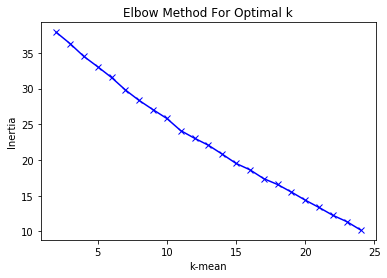

In [8]:
inertia = []

for cluster in Krange:
    kmean = KMeans(n_clusters=cluster, random_state=1021)
    kmean = kmean.fit(X)
    inertia.append(kmean.inertia_)
    
plt.plot(Krange, inertia, 'bx-')
plt.xlabel('k-mean')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# However the plot below is not necessary all clear, certainly not when there is not an "elbow"

In [9]:
# After a research, I have identified Yellowbrick, a wrapper for the Scikit-Learn API 
# that facilitate the visualization of several things including Elbow and Silhouette

# Install the library. This can be achieved from Jupyter too provided the right method is used
# no harm in executing. If the library is installed already, Jupyter will prompt a "requirements are satisfied" message.

#import sys
#!{sys.executable} -m pip install yellowbrick

In [9]:
from yellowbrick.cluster import KElbowVisualizer

# Set the kmean to a fixed random_state for reproduceability
kmean = KMeans(random_state=1021)

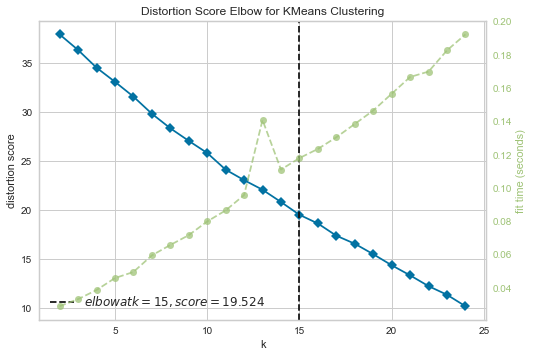

In [10]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(kmean, k=Krange)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()  

# Any error in identifying the elbow means that the right number of clusters was not found and
# perhaps more items to train the classifier are required, or different fine tunes.

In [12]:
print(f'{"No elbows found" if visualizer.elbow_value_ == None else str(visualizer.elbow_value_) + " cluster(s) found"} with this corpus')

15 found with this corpus


### 1.4) Text classification with K-Means

Although the KMeans has been used above, this is effectively the first time where I'm collecting the results to later compare them against the different algorithms.

In [13]:
# Execute the clusterization
# - I specify either the right number of clusters found above OR
# - an hypothetical number I believe to be correct
num_clusters = 15
kmean = KMeans(n_clusters=num_clusters, random_state=1021)
%time clusters = kmean.fit_predict(X) 
#kmean.fit(X)

CPU times: user 159 ms, sys: 13.2 ms, total: 172 ms
Wall time: 176 ms


### 1.5) Data visualization

Populate the Dataframe with the outcome of this clusterization process

In [14]:
# Get a list of keywords that was deemed important in each document of the corpus
data['Kmeans Keywords'] = getKeywordsFromVector(keywsVoc, X) 

# Get also the cluster where a document was assigned
data['Kmeans Cluster'] = clusters #kmean.labels_.tolist()

In [ ]:
###
### This is an experiment on how to intercept the data in the cluster
### It's not a functional part of this example
###

# cluster_0 = np.where(clusters==0)
# print(cluster_0)

# # cluster_0 now contains all indices of the documents in this cluster, to get the actual documents you'd do:
# X_cluster_0 = X[cluster_0]
# print(X_cluster_0)

In [ ]:
###
### This is an experiment not functional to this example
###
### The distance metrics

# from scipy.spatial.distance import euclidean

# distance = euclidean(X_cluster_0[0].toarray(), kmean.cluster_centers_[0])
# print(distance)

In [16]:
print(f'Number of clusters: {num_clusters}', end='\n\n')

printClusters(keywsVoc, num_clusters, kmean.cluster_centers_, 'Kmeans Cluster')

Number of clusters: 15

Top terms per cluster:

Cluster 0 words:
 Keyword                  Value     
-----------------------------------
 Average                  0.08826566475009712
 - - - - - - - - - - - - - - - - -
 baloon                   0.09558571239187387
 doll                     0.10101525445522108
 guy                      0.0926684554939994
 japanes                  0.10101525445522108
 walk                     0.1491627865264223
 water                    0.10616748490872378

Cluster 0 titles:
 The man is walking in the street.
 The baloon is in the water.
 In the road, the guy walks.
 This is a Japanese doll.
 Mary plays the piano.
 She always speaks to him in a loud voice.
 A glittering gem is not enough.


Cluster 1 words:
 Keyword                  Value     
-----------------------------------
 Average                  0.575982632625751
 - - - - - - - - - - - - - - - - -
 track                    0.6040659038636469
 train                    0.6040659038636469

Cluster 

In [ ]:
# # This prints the keywords falling in the cluster where which a given keywords has been attached
# for kkkk in (np.flatnonzero(kmean.cluster_centers_[kmean.predict(X[i])])):
#     print(keywsVoc.get(kkkk))

# print()
    
# # This prints the list of keywords in a given cluster
# for kkkk in (np.flatnonzero(kmean.cluster_centers_[i])):
#     print(keywsVoc.get(kkkk))

Clusterization algorithm like the K-Means are based on proximity of the element from a certain center.<br>
In theory no one item should fall into different clusters.

Let's verify it.

In [17]:
# Find any duplicate item across the clusters
import numpy as np
from collections import Counter

# The Numpy nonzero returns a data structure containins two indices: 
# - 0, with the position of the cluster, 
# - 1 with the term's index
a = np.nonzero(kmean.cluster_centers_)

# Build a list of items where the count is greater than 1
dup = [item for item, count in Counter(a[1]).items() if count > 1]

# Loop through the duplicates list, and print out the terms and the cluster where the duplication occurred
[[keywsVoc[d], a[0][index]] for d in dup for index, item in list(enumerate(a[1])) if item == d]

[['baloon', 0],
 ['baloon', 3],
 ['play', 0],
 ['play', 7],
 ['road', 0],
 ['road', 6],
 ['walk', 0],
 ['walk', 7],
 ['run', 1],
 ['run', 10],
 ['dark', 2],
 ['dark', 7],
 ['dark', 8],
 ['time', 2],
 ['time', 14],
 ['air', 3],
 ['air', 8],
 ['flight', 3],
 ['flight', 4],
 ['sky', 3],
 ['sky', 8],
 ['take', 3],
 ['take', 7],
 ['take', 14],
 ['fli', 4],
 ['fli', 8],
 ['pilot', 4],
 ['pilot', 14],
 ['dont', 7],
 ['dont', 8],
 ['say', 7],
 ['say', 14]]

### Sklearn TD-IDF Kmeans Conclusions

I have obtained a clusterization of my documents. In analysing the vectors, it was noticed that some terms have an overlap: 15 of them out of 33 unique terms, or 1/2 of the dataset. This is not a great result (IMHO)

- Is this because of the inappropriate usage of Kmeans on vectors made from documents (although converted into numbers)?
- Is this becaise the limited number of vectors hence when forming the clusters, similar keywords have been split to cover several sentences?
- Is this overlap due to the fact that in analysing the results, the whole group of items in a cluster is assessed (compared) and not just the top X near to the center?

I believe the correct answer sits in between the 2nd and 3rd item above.

### 1.4a) Text classification with KMode

KMode is algorithm for categorical clustering.

### Determining the right number of clusters
The nature of my data (Documents) doesn't fit the purpose, but it's worth a try to see what I'm going to get out of here.

In [18]:
from kmodes.kmodes import KModes

kmod_clust_num = 11
kmod = KModes(n_clusters=kmod_clust_num, init='CAO', n_init=3)#, verbose=1)
kmod.fit_predict(X.toarray())

# Assign the cluser labels back to the dataframe
data['KMode cluster'] = kmod.labels_.tolist()

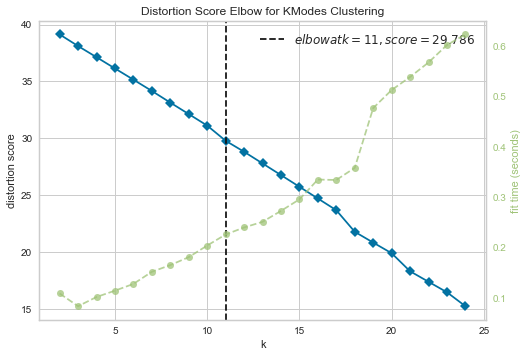

In [20]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(kmod, k=Krange)
visualizer.fit(X.toarray())        # Fit the data to the visualizer
visualizer.show()  

In [21]:
printClusters(keywsVoc, kmod_clust_num, kmod.cluster_centroids_, 'KMode cluster')

Top terms per cluster:

Cluster 0 words:
 Keyword                  Value     
-----------------------------------
 Average                  nan       
 - - - - - - - - - - - - - - - - -

Cluster 0 titles:
 The car is driven on the road.
 The truck is driven on the highway.
 The train run on the tracks.
 The bycicle is run on the pavement.
 The flight is conducted in the air.
 The baloon is conducted in the air.
 The bird is flying in the air.
 The man is walking in the street.
 The pedestrian is crossing the zebra.
 The pilot flights the plane.
 On the route, the car is driven.
 On the road, the truck is moved.
 The train is running on the tracks.
 The bike is running on the pavement.
 The flight takes place in the sky.
 The baloon is in the water.
 The bird flies in the sky.
 In the road, the guy walks.
 The pedestrian is passing through the zebra.
 The pilot is flying the plane.
 This is a Japanese doll.
 Christmas is coming.
 Mary plays the piano.
 She always speaks to him in a loud

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### KMode Conclusions
The results achieved are everything but encouraging. As expected, being my feature non-omogeneous documents, the resulting classification failed. 

### Sklearn TD-IDF Conclusions
- Sklearn TD-IDF seems suitable for text classification and clusterisation only when used with the K-Means
- With a limited set of documents, there is a kinf of inevitable overlap

## 2) Gensim TF-IDF method

### 2.1) Text Transformation

The TF-IDF implementation of Gensim requires the corpus and the dictionary in a different format, which I will be preparing later on.

In [23]:
from gensim import corpora

## Uncomment the following if executing this module on its own
# from nltk import word_tokenize, sent_tokenize 
# from nltk.corpus import stopwords
# import string

In [24]:
# Remove common words and tokenize
# do it using the routine created before
texts = [
    word_tokenizer(document, False)
    for document in corpus
]

dictionary = corpora.Dictionary(texts)

# Prepare a Keyword dictionary in the format expceted by my routine
GensimKeywsVoc = {key: value for (value, key) in dictionary.token2id.items()}

## Initial approach
## flat_list = [item for sublist in texts for item in sublist]
## indexes = [i for block in texts for i in dictionary.doc2idx(block)]
## GensimKeywsVoc = dict(zip(indexes, flat_list))

### 2.2) Text Modelling

In [25]:
from gensim.models.tfidfmodel import TfidfModel

# The gensim TF-IDF model requires a data structure in a Bag of Word format (which is still a vector).
new_corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(new_corpus)
corpus_tfidf = tfidf[new_corpus]

# Create a data structure suitable for the K-Means clusterization
from gensim.matutils import corpus2csc
X = corpus2csc(corpus_tfidf).transpose()

### 2.3) Data representation

Determining the right number of clusters using the K-Means and the Elbow method

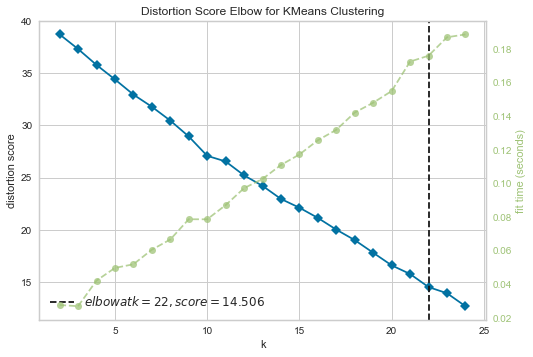

In [26]:
# Plot the graph to undestand the right number of clusters
visualizer = KElbowVisualizer(kmean, k=Krange)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

### 2.4) Data Visualization

In [27]:
num_clusters = 22

from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=num_clusters, random_state=1021)
clusters = kmean.fit_predict(X) 

# Get a list of keywords that was deemed important in each document of the corpus
data['Gensim TF-IDF Keywords'] = getKeywordsFromVector(GensimKeywsVoc, X) 

# Get also the cluster where a document was assigned
data['Gensim TF-IDF Cluster'] = clusters #kmean.labels_.tolist()

In [28]:
print(f'{num_clusters} clusters were used')
print()
printClusters(GensimKeywsVoc, num_clusters, kmean.cluster_centers_, 'Gensim TF-IDF Cluster')

22 clusters were used

Top terms per cluster:

Cluster 0 words:
 Keyword                  Value     
-----------------------------------
 Average                  0.4308742063869282
 - - - - - - - - - - - - - - - - -
 pedestrian               0.5339754971077073
 zebra                    0.5339754971077073

Cluster 0 titles:
 The pedestrian is crossing the zebra.
 The pedestrian is passing through the zebra.


Cluster 1 words:
 Keyword                  Value     
-----------------------------------
 Average                  0.32423567173323603
 - - - - - - - - - - - - - - - - -
 air                      0.34838796578259806
 conducted                0.40191433772777235
 baloon                   0.4114738365360206

Cluster 1 titles:
 The flight is conducted in the air.
 The baloon is conducted in the air.
 The baloon is in the water.


Cluster 2 words:
 Keyword                  Value     
-----------------------------------
 Average                  0.13770386375581517
 - - - - - - - - - 

In [29]:
# If of any interest, it may be possible to see how the keywords have been weighted

def show_keywords_tfidf_weigth(corpus=new_corpus):
    # Show the TF-IDF weights
    from gensim.models.tfidfmodel import TfidfModel
    tfidf = TfidfModel(corpus)

    for doc in tfidf[corpus]:
        print([[dictionary[id], np.around(freq, decimals=2)] for id, freq in doc])
        

def show_keywords_freq_in_corpus(list_of_list_of_keywords=texts, corpus=new_corpus):
    ##
    # Count the numerical frequency of terms across the whole corpus and 
    # return how many times each terms has been used irrespective of the document
    ##
    from collections import defaultdict
    
    frequency = defaultdict(int)
    for text in list_of_list_of_keywords:
        for token in text:
            frequency[token] += 1

    for doc in corpus:
        print([[dictionary[id[0]], np.around(frequency[dictionary[id[0]]], decimals=2)] for id in doc])
        

def show_keywords_freq_in_docs(corpus=new_corpus):
    ##
    # Count the numerical frequency of terms within each document
    ##
    for doc in new_corpus:
        print([[dictionary[id], np.around(freq, decimals=2)] for id, freq in doc])
        


# show_keywords_tfidf_weigth()
# print()

# show_keywords_frequency_in_corpus()
# print()

# show_keywords_freq_in_docs
# print()

### Gensim TF-IDF Conclusions

- Gensim TF-IDF so far seems to be the best approach to cluster documents in a corpus.
- Given the current dataset, a number of cluster was identified
- A preliminary inspection of the details give me a good level of 'confidence'

## 3) Doc2Vec Implementation

In [30]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

### 3.1) Text Transformation - Using the Simple_Preprocess approach

In [31]:
texts = [
    simple_preprocess(document)
    for document in corpus
]

# In order to do some data representation later on, I still need to create a dictionary of words
# Leaning on the Corpora Dictionary class
dictionary = corpora.Dictionary(texts)

# and prepare a Keyword dictionary in the format expceted by my routine
Doc2VecSPKeywsVoc = {key: value for (value, key) in dictionary.token2id.items()}

# Add the list of keywords to my dataframe
data['Doc2Vec SP Keywords'] = texts

### 3.2) Text Modelling

In [32]:
# Doc2Vec requires data formatted as TaggedDocument
new_corpus = [TaggedDocument(words, [i]) for i, words in enumerate(texts)]

# it could have been done also as
#   new_corpus = [TaggedDocument(simple_preprocess(doc), [i]) for i, doc in enumerate(corpus)]
#
# but ended up using the approach above to:
# - create a correlation with the code structure (after all this is still a learing prototype) 
# - re-use some code

model = Doc2Vec(new_corpus, window=2, min_count=2, workers=4)
X = model.docvecs.vectors_docs #doctag_syn0

### 3.3) Data representation

Determining the right number of clusters using the K-Means and the Elbow method

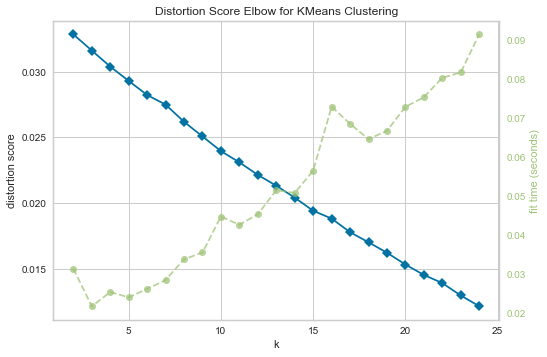

In [33]:
# Plot the graph to undestand the right number of clusters
visualizer = KElbowVisualizer(kmean, k=Krange, locate_elbow=False)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

In [34]:
print(f'{"No elbows found" if visualizer.elbow_value_ == None else str(visualizer.elbow_value_) + " cluster(s) found"} with this corpus')

No elbows found with this corpus


In [35]:
# Since no elbows, I assume 13 to be a good number
num_clusters = 13
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, random_state=1021)

# To obtain the clusters do either
# -- kmeans_model.fit(model.docvecs.doctag_syn0)
# -- clusters=kmeans_model.labels_.tolist()
# OR
# -- clusters = kmeans_model.fit_predict(X) 
#
# I personally prefer the second option

clusters = kmeans_model.fit_predict(X) 

# Assign the cluser labels back to the dataframe
data['Doc2Vec SP cluster'] = clusters

### 3.4) Data Visualization 

In [36]:
printClusters(Doc2VecSPKeywsVoc, num_clusters, kmeans_model.cluster_centers_, 'Doc2Vec SP cluster')

Top terms per cluster:

Cluster 0 words:
 Keyword                  Value     
-----------------------------------
 Average                  -0.00014544559235218912
 - - - - - - - - - - - - - - - - -
 car                      0.004064589273184538
 driven                   0.004172361455857754
 is                       0.0029864776879549026
 on                       0.001158590312115848
 road                     0.0013750693760812283
 the                      0.004618078004568815
 highway                  0.000994751462712884
 run                      0.00025164321414195
 train                    0.0010249195620417595
 bycicle                  0.003688161727041006
 conducted                0.0036557121202349663
 in                       0.00028785772155970335
 baloon                   0.0005221320316195488
 man                      0.0015297688078135252
 walking                  0.0013445677468553185
 crossing                 0.0006223664386197925
 pedestrian               0.003693431615

### 3.1a) Text Transformation - Using the Word tokenizer approach

In [37]:
texts = [
    word_tokenizer(document, False)
    for document in corpus
]

# In order to do some data representation later using my approach, I still need to create a dictionary of words
dictionary = corpora.Dictionary(texts)

# and prepare a Keyword dictionary in the format expceted by my routine
Doc2VecWTKeywsVoc = {key: value for (value, key) in dictionary.token2id.items()}

# Add the list of keywords to my dataframe
data['Doc2Vec WT Keywords'] = texts

### 3.2a) Text Modelling

In [38]:
# Doc2Vec requires data formatted as TaggedDocument
new_corpus = [TaggedDocument(words, [i]) for i, words in enumerate(texts)]

# it could have been done also as
#   new_corpus = [TaggedDocument(simple_preprocess(doc), [i]) for i, doc in enumerate(corpus)]
#
# but ended up using the approach above to:
# - create a correlation with the code structure (after all this is still a learing prototype) 
# - re-use some code

model = Doc2Vec(new_corpus, window=2, min_count=2, workers=4)
X = model.docvecs.vectors_docs #doctag_syn0

### 3.3a) Data representation

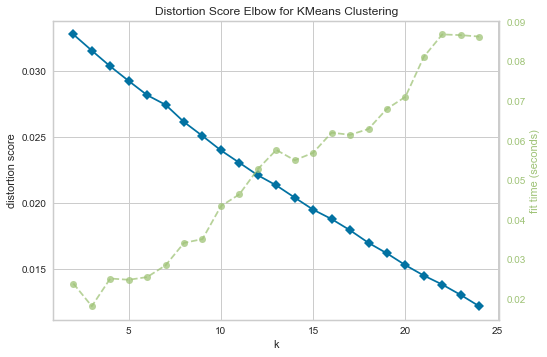

In [40]:
# Plot the graph to undestand the right number of clusters
visualizer = KElbowVisualizer(kmean, k=Krange, locate_elbow=False)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

In [41]:
print(f'{"No elbows found" if visualizer.elbow_value_ == None else str(visualizer.elbow_value_) + " cluster(s) found"} with this corpus')

No elbows found with this corpus


In [42]:
# Since no elbows, I assume 13 to be a good number
num_clusters = 13
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, random_state=1021)

# To obtain the clusters do either
# -- kmeans_model.fit(model.docvecs.doctag_syn0)
# -- clusters=kmeans_model.labels_.tolist()
# OR
# -- clusters = kmeans_model.fit_predict(X) 
#
# I personally prefer the second option

clusters = kmeans_model.fit_predict(X) 

# Assign the cluser labels back to the dataframe
data['Doc2Vec WT cluster'] = clusters

### 3.4a) Data Visualization 

In [43]:
printClusters(Doc2VecWTKeywsVoc, num_clusters, kmeans_model.cluster_centers_, 'Doc2Vec WT cluster')

Top terms per cluster:

Cluster 0 words:
 Keyword                  Value     
-----------------------------------
 Average                  -0.00014458202349487692
 - - - - - - - - - - - - - - - - -
 car                      0.00406191311776638
 driven                   0.004214984830468893
 road                     0.0029972123447805643
 highway                  0.0011813566088676453
 truck                    0.0014074534410610795
 run                      0.00460524158552289
 tracks                   0.0009965335484594107
 bycicle                  0.0002751232823356986
 air                      0.0010165272979065776
 conducted                0.003683919319882989
 bird                     0.003612757893279195
 man                      0.00028229327290318906
 street                   0.0005202143802307546
 pedestrian               0.0015310568269342184
 flights                  0.0013707237085327506
 pilot                    0.0006374377990141511
 plane                    0.00367000699

### Doc2Vec conclusions
- Using the Doc2Vec was successfully completed with two different text transformation processes
- Irrespective of the above, the Elbow method was not able to clearly identify the number of correct clusters, which was assumed in 13 to progress (both the circumstances)
- Looking at the results of the clusterization processes, it was noticed the following:
    - No difference in terms of final clusterisation
        - Has the text transformation a real effect on the modelling? At present this doesn't seem to be the case.
    - The keywords dictionary is of course difference and bigger when the `Simple Process` is used
    - When using my routine to print the most significant keywords that contributed to a cluster, the keywords value is different but not the centroid attached. 
        - This suggests a problem with my routine that need to be further inverstigated.

# Conclusions

In [44]:
data

,document,Kmeans Keywords,Kmeans Cluster,KMode cluster,Gensim TF-IDF Keywords,Gensim TF-IDF Cluster,Doc2Vec SP Keywords,Doc2Vec SP cluster,Doc2Vec WT Keywords,Doc2Vec WT cluster
0,The car is driven on the road.,"[road, driven, car]",6,0,"[car, driven, road]",5,"[the, car, is, driven, on, the, road]",1,"[car, driven, road]",1
1,The truck is driven on the highway.,"[highway, truck, driven]",6,0,"[driven, highway, truck]",4,"[the, truck, is, driven, on, the, highway]",8,"[truck, driven, highway]",8
2,The train run on the tracks.,"[track, run, train]",1,0,"[run, tracks, train]",3,"[the, train, run, on, the, tracks]",3,"[train, run, tracks]",3
3,The bycicle is run on the pavement.,"[pavement, bycicl, run]",10,0,"[run, bycicle, pavement]",16,"[the, bycicle, is, run, on, the, pavement]",6,"[bycicle, run, pavement]",6
4,The flight is conducted in the air.,"[air, conduct, flight]",3,0,"[air, conducted, flight]",1,"[the, flight, is, conducted, in, the, air]",3,"[flight, conducted, air]",3
5,The baloon is conducted in the air.,"[baloon, air, conduct]",3,0,"[air, conducted, baloon]",1,"[the, baloon, is, conducted, in, the, air]",9,"[baloon, conducted, air]",9
6,The bird is flying in the air.,"[fli, bird, air]",8,0,"[air, bird, flying]",8,"[the, bird, is, flying, in, the, air]",6,"[bird, flying, air]",6
7,The man is walking in the street.,"[street, walk, man]",0,0,"[man, street, walking]",2,"[the, man, is, walking, in, the, street]",1,"[man, walking, street]",1
8,The pedestrian is crossing the zebra.,"[zebra, cross, pedestrian]",13,0,"[crossing, pedestrian, zebra]",0,"[the, pedestrian, is, crossing, the, zebra]",3,"[pedestrian, crossing, zebra]",3
9,The pilot flights the plane.,"[plane, pilot, flight]",4,0,"[flights, pilot, plane]",6,"[the, pilot, flights, the, plane]",1,"[pilot, flights, plane]",1


- Several algorithms have been tested to identify the best approach to cluster a corpus of documents. 
- A real document, however, is much longer than a symbolic sentence as the ones provided. I would expect different outcomes in a more controlled enviroment.
- From the results obtained during this text clusterization, Gensim Corpora seems to be the most valid algorithm